Using TensorFlow backend.


Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeBCNN
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 100 forward passes, 182.38s elapsed
3.296203917264938 -0.41874406635761263
1.9704117953777314 1.9550928980112077
Finished all gradient calculation, 1.70 seconds elapsed
Finished all gradient calculation, 1.70 seconds elapsed
Finished all gradient calculation, 3.34 seconds elapsed


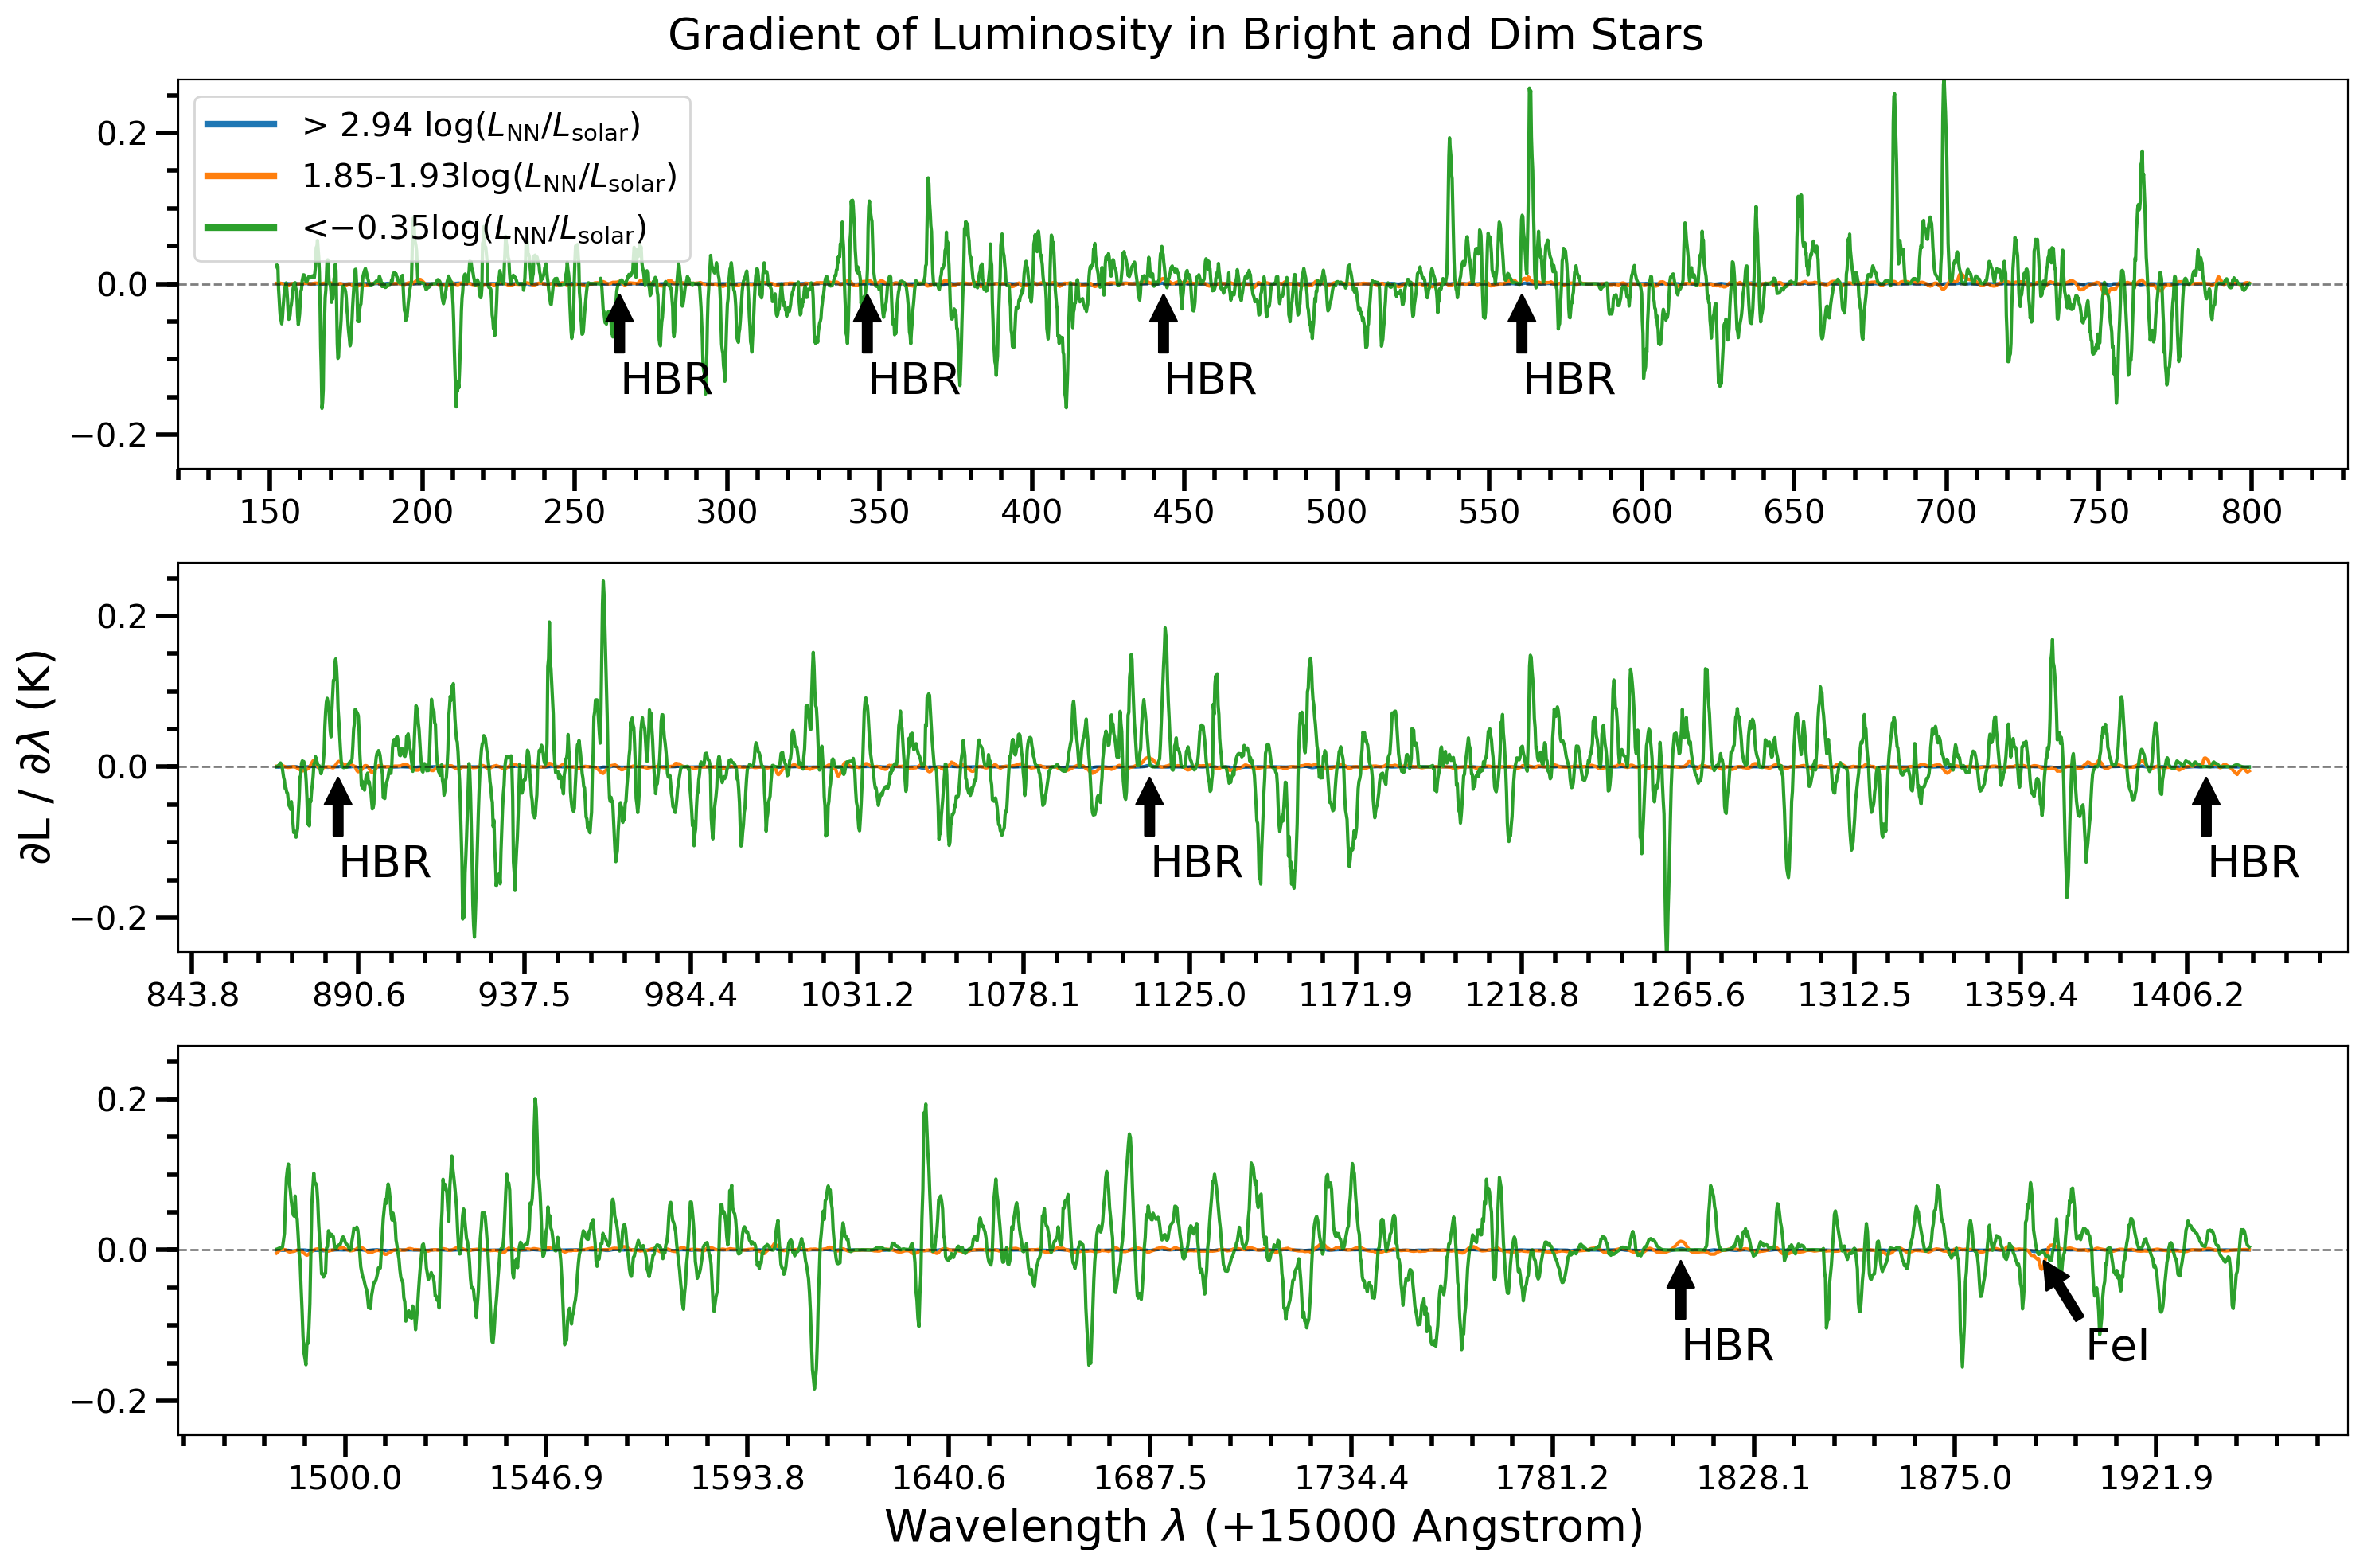

In [1]:
%matplotlib inline
import pylab as plt
import matplotlib.ticker as ticker
from astroNN.apogee.chips import wavelength_solution, chips_split

import h5py
import numpy as np
from astroNN.models import load_folder
from astroNN.gaia import fakemag_to_logsol

net = load_folder("astroNN_Ks_fakemag_adversial")

with h5py.File("gaia_dr2_train.h5", 'r') as f:
    spectra = np.array(f['spectra'])
    
pred, pred_err = net.test(spectra)

good_idx = [pred[:, 0] / pred_err['total'][:, 0] > 5]
logsol = fakemag_to_logsol(pred[:, 0][good_idx])

print(np.percentile(logsol, 97.5), np.percentile(logsol, 2.5))
print(np.percentile(logsol, 57.5), np.percentile(logsol, 52.5))

jac_bright = net.jacobian(spectra[good_idx][logsol > np.percentile(logsol, 97.5)], mean_output=True)
jac_dim = net.jacobian(spectra[good_idx][logsol < np.percentile(logsol, 2.5)], mean_output=True)
jac_middle = net.jacobian(spectra[good_idx][(logsol < np.percentile(logsol, 57.5)) & 
                                            (logsol > np.percentile(logsol, 52.5))], mean_output=True)
# define HBR lines for plotting# define 
HBR_blue_lines = np.array([15264.717, 15345.992, 15443.148, 15560.708]) - 15000.
HBR_green_lines = np.array([15884.888, 16113.721, 16411.681]) - 15000.
HBR_red_lines = np.array([16811.117]) - 15000.

lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=14)

lambda_blue -= 15000
lambda_green -= 15000
lambda_red -= 15000

nn_neuron = 0
target_name = 'T_{eff}'

fig = plt.figure(figsize=(15, 10), dpi=200)
bright_jac_b, bright_jac_g, bright_jac_r = chips_split(jac_bright, dr=14)
dim_jac_b, dim_jac_g, dim_jac_r = chips_split(jac_dim, dr=14)
middle_jac_b, middle_jac_g, middle_jac_r = chips_split(jac_middle, dr=14)

min_jacpoint = np.min([np.min(jac_dim), np.min(jac_bright)])
max_jacpoint = np.max([np.max(jac_dim), np.max(jac_bright)])

fig.suptitle(f'Gradient of Luminosity in Bright and Dim Stars', fontsize=20)
ax1 = fig.add_subplot(311)
ax1.plot(lambda_blue, bright_jac_b[nn_neuron], linewidth=1.5, 
         label='> 2.94 ' + r'$\log (L_\mathrm{NN} /L_\mathrm{solar})$')
ax1.plot(lambda_blue, middle_jac_b[nn_neuron], linewidth=1.5, 
         label='1.85-1.93' + r'$\log (L_\mathrm{NN} /L_\mathrm{solar})$')
ax1.plot(lambda_blue, dim_jac_b[nn_neuron], linewidth=1.5, 
         label='<' + '$-0.35$' + r'$\log (L_\mathrm{NN} /L_\mathrm{solar})$')
ax1.set_ylim((min_jacpoint, max_jacpoint))
ax2 = fig.add_subplot(312)
ax2.set_ylabel(r'$\partial$' + 'L / ' + r'$\partial\lambda$ (K)', fontsize=20)
ax2.plot(lambda_green, bright_jac_g[nn_neuron], linewidth=1.5, label='Bight')
ax2.plot(lambda_green, middle_jac_g[nn_neuron], linewidth=1.5, label='Middle')
ax2.plot(lambda_green, dim_jac_g[nn_neuron], linewidth=1.5, label='Dim')
ax2.set_ylim((min_jacpoint, max_jacpoint))
ax3 = fig.add_subplot(313)
ax3.plot(lambda_red, bright_jac_r[nn_neuron], linewidth=1.5, label='Bright')
ax3.plot(lambda_red, middle_jac_r[nn_neuron], linewidth=1.5, label='Middle')
ax3.plot(lambda_red, dim_jac_r[nn_neuron], linewidth=1.5, label='Dim')
ax3.set_ylim((min_jacpoint, max_jacpoint))

ax1.tick_params(labelsize=15, width=2, length=10, which='major')
ax1.tick_params(width=2, length=5, which='minor')
ax2.tick_params(labelsize=15, width=2, length=10, which='major')
ax2.tick_params(width=2, length=5, which='minor')
ax3.tick_params(labelsize=15, width=2, length=10, which='major')
ax3.tick_params(width=2, length=5, which='minor')
leg = ax1.legend(loc='best', fontsize=15)
ax3.set_xlabel(r'Wavelength $\lambda$ (+15000 Angstrom)', fontsize=20)

ax1.axhline(0, ls='--', c='k', lw=1, alpha=0.5)
ax2.axhline(0, ls='--', c='k', lw=1, alpha=0.5)
ax3.axhline(0, ls='--', c='k', lw=1, alpha=0.5)

for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

for HBR_blue_line in HBR_blue_lines:
    ax1.annotate('HBR', xy=(HBR_blue_line, -0.01), xytext=(HBR_blue_line, min_jacpoint + 0.1), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

for HBR_green_line in HBR_green_lines:
    ax2.annotate('HBR', xy=(HBR_green_line, -0.01), xytext=(HBR_green_line, min_jacpoint + 0.1), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

for HBR_red_line in HBR_red_lines:
    ax3.annotate('HBR', xy=(HBR_red_line, -0.01), xytext=(HBR_red_line, min_jacpoint + 0.1), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

ax3.annotate('FeI', xy=(1895.183, -0.01), xytext=(1895.183 + 10., min_jacpoint + 0.1), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)
    
tick_spacing = 75
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.5))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.6))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.6))
ax1.minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()
plt.tight_layout(rect=[0, 0.00, 1, 0.96])
# plt.savefig("jac_teff_fe.pdf")

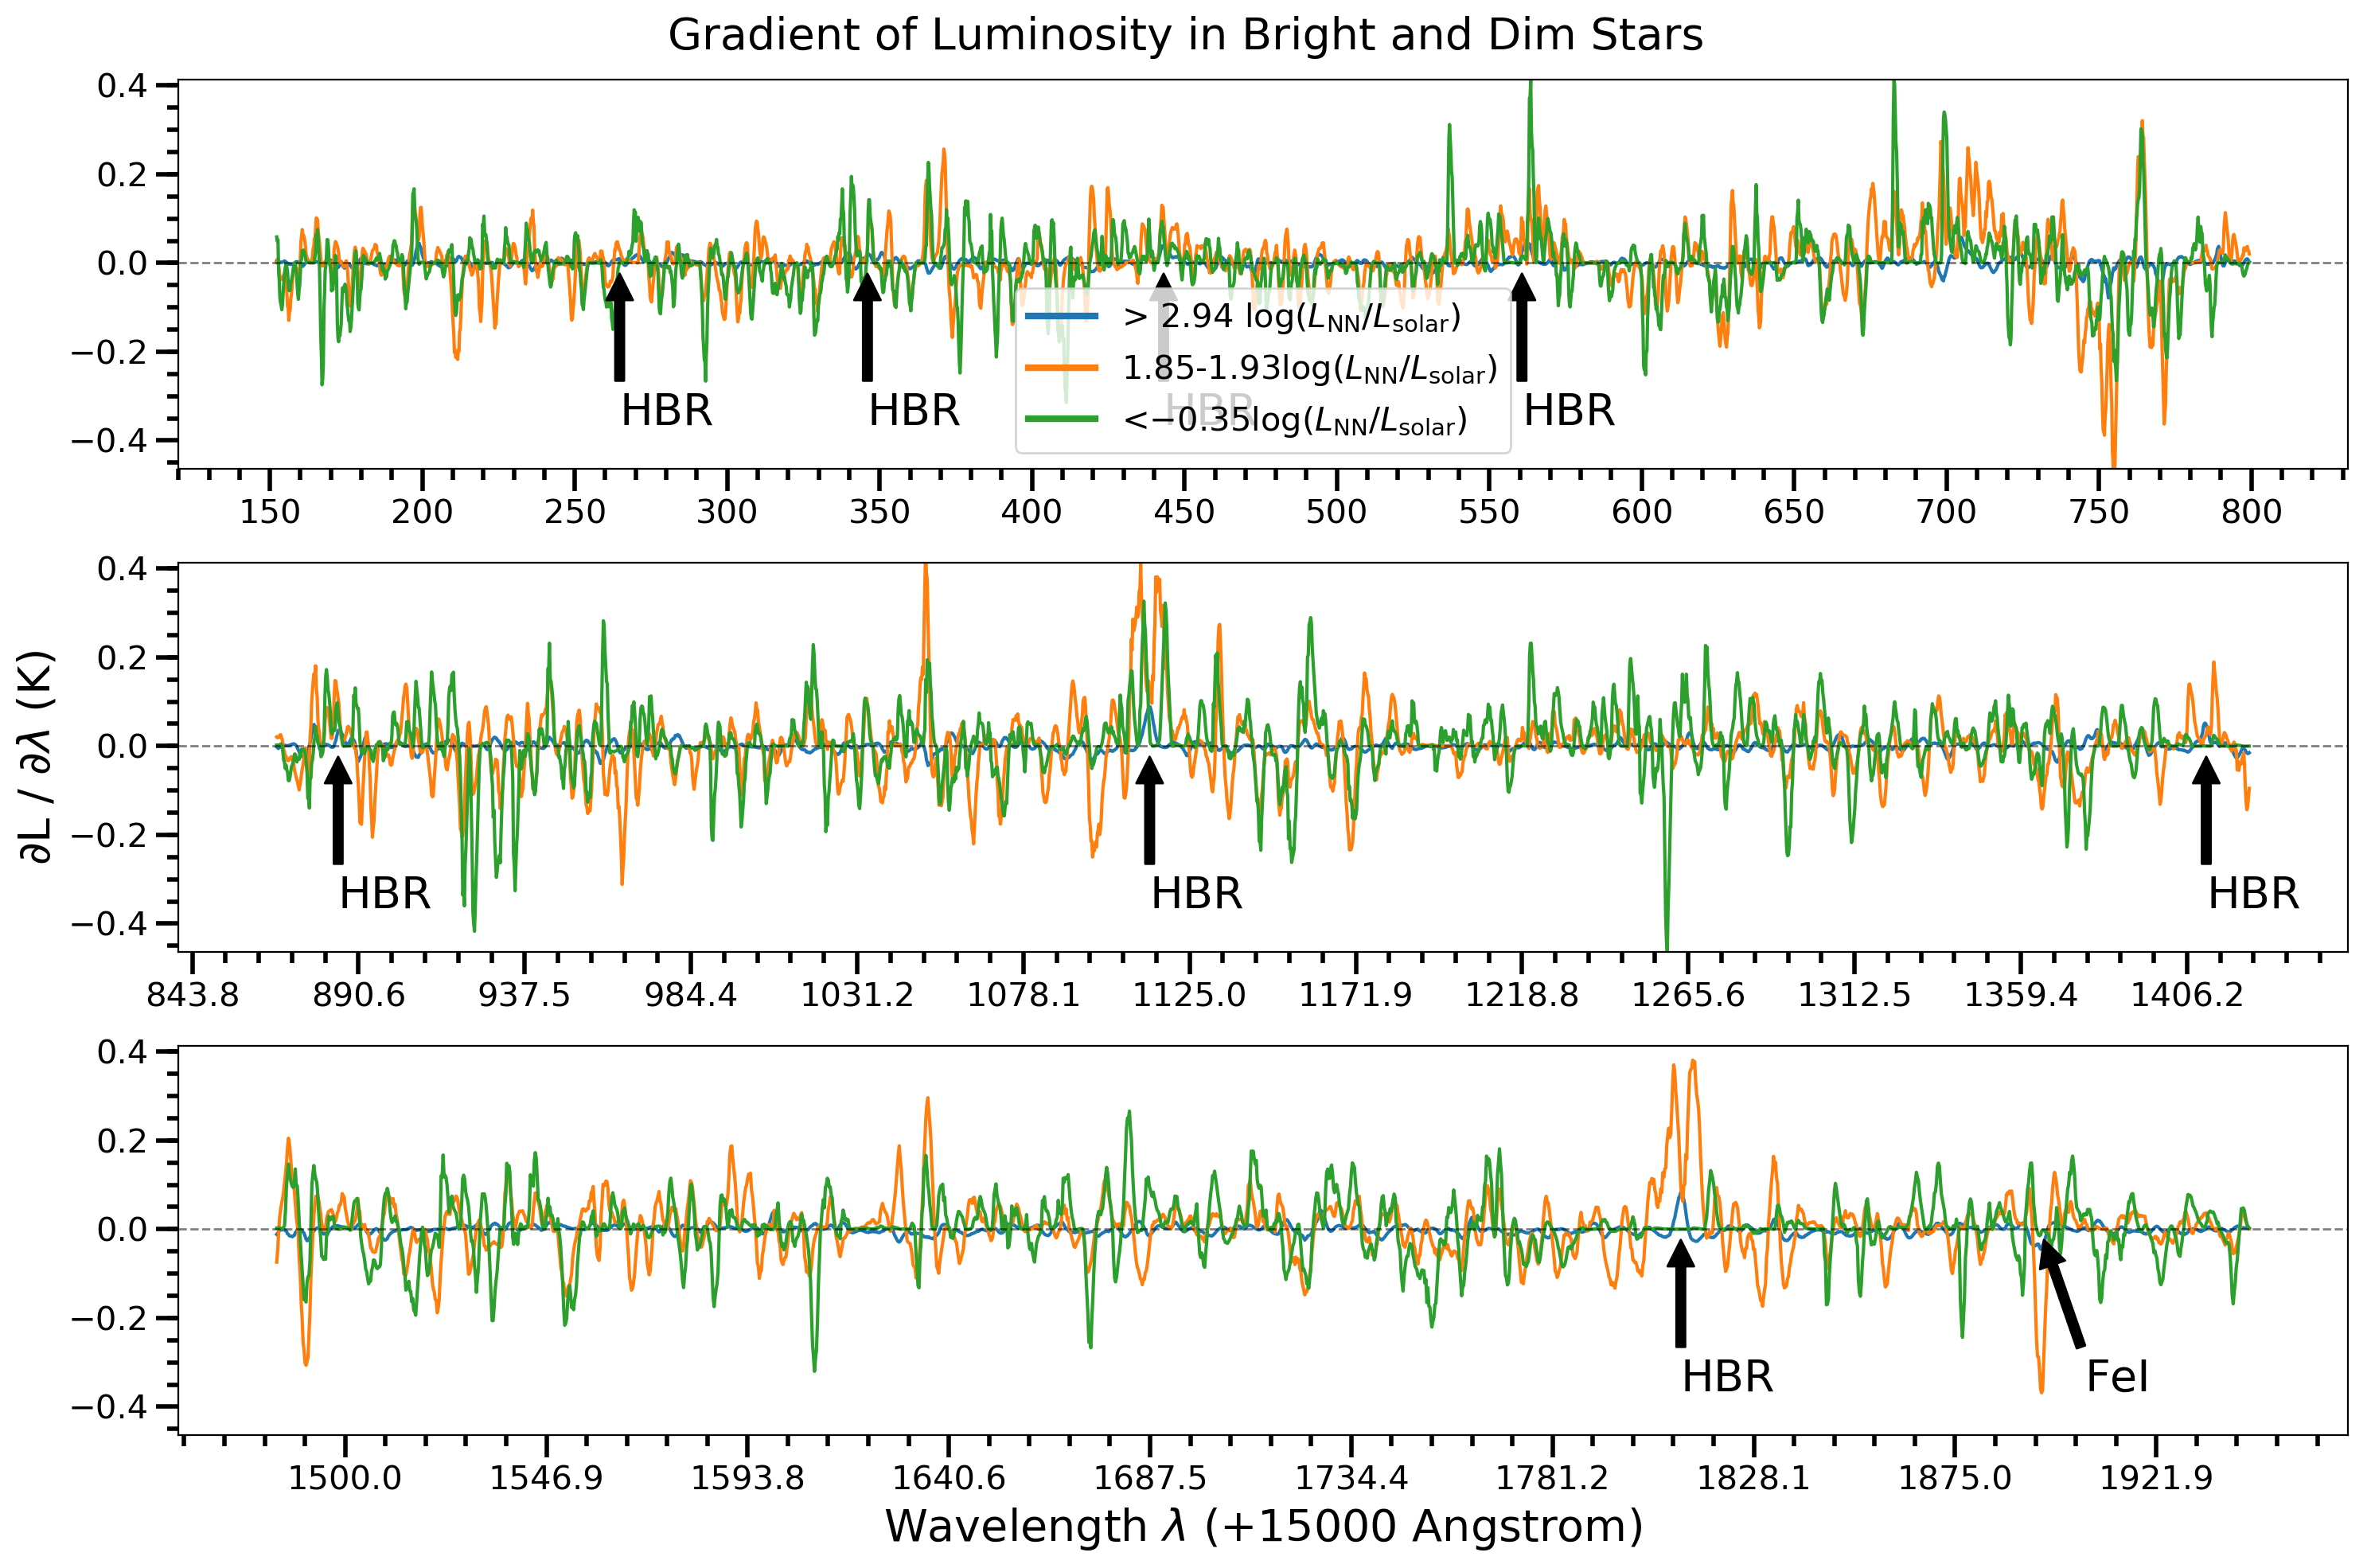

In [4]:
# %matplotlib inline
# import pylab as plt
# import matplotlib.ticker as ticker
# from astroNN.apogee.chips import wavelength_solution, chips_split

# import h5py
# import numpy as np
# from astroNN.models import load_folder
# from astroNN.gaia import fakemag_to_logsol

# net = load_folder("astroNN_Ks_fakemag_adversial")

# with h5py.File("gaia_dr2_test.h5", 'r') as f:
#     spectra = np.array(f['spectra'])
    
# pred, pred_err = net.test(spectra)

# good_idx = [pred[:, 0] / pred_err['total'][:, 0] > 5]
# logsol = fakemag_to_logsol(pred[:, 0][good_idx])

# print(np.percentile(logsol, 97.5), np.percentile(logsol, 2.5))
# print(np.percentile(logsol, 57.5), np.percentile(logsol, 52.5))

# jac_bright = net.jacobian(spectra[good_idx][logsol > np.percentile(logsol, 97.5)], mean_output=True)
# jac_dim = net.jacobian(spectra[good_idx][logsol < np.percentile(logsol, 2.5)], mean_output=True)
# jac_middle = net.jacobian(spectra[good_idx][(logsol < np.percentile(logsol, 57.5)) & 
#                                             (logsol > np.percentile(logsol, 52.5))], mean_output=True)

# define HBR lines for plotting# define 
HBR_blue_lines = np.array([15264.717, 15345.992, 15443.148, 15560.708]) - 15000.
HBR_green_lines = np.array([15884.888, 16113.721, 16411.681]) - 15000.
HBR_red_lines = np.array([16811.117]) - 15000.

lambda_blue, lambda_green, lambda_red = wavelength_solution(dr=14)

lambda_blue -= 15000
lambda_green -= 15000
lambda_red -= 15000

nn_neuron = 0
target_name = 'T_{eff}'

fig = plt.figure(figsize=(15, 10), dpi=200)
bright_jac_b, bright_jac_g, bright_jac_r = chips_split(jac_bright*5, dr=14)
middle_jac_b, middle_jac_g, middle_jac_r = chips_split(jac_middle*5, dr=14)
dim_jac_b, dim_jac_g, dim_jac_r = chips_split(jac_dim, dr=14)

min_jacpoint = np.min([np.min(jac_dim), np.min(jac_bright)])
max_jacpoint = np.max([np.max(jac_dim), np.max(jac_bright)])

fig.suptitle(f'Gradient of Luminosity in Bright and Dim Stars', fontsize=20)
ax1 = fig.add_subplot(311)
ax1.plot(lambda_blue, bright_jac_b[nn_neuron], linewidth=1.5, 
         label='> 2.94 ' + r'$\log (L_\mathrm{NN} /L_\mathrm{solar})$')
ax1.plot(lambda_blue, middle_jac_b[nn_neuron], linewidth=1.5, 
         label='1.85-1.93' + r'$\log (L_\mathrm{NN} /L_\mathrm{solar})$')
ax1.plot(lambda_blue, dim_jac_b[nn_neuron], linewidth=1.5, 
         label='<' + '$-0.35$' + r'$\log (L_\mathrm{NN} /L_\mathrm{solar})$')
ax1.set_ylim((min_jacpoint, max_jacpoint))
ax2 = fig.add_subplot(312)
ax2.set_ylabel(r'$\partial$' + 'L / ' + r'$\partial\lambda$ (K)', fontsize=20)
ax2.plot(lambda_green, bright_jac_g[nn_neuron], linewidth=1.5, label='Bight')
ax2.plot(lambda_green, middle_jac_g[nn_neuron], linewidth=1.5, label='Middle')
ax2.plot(lambda_green, dim_jac_g[nn_neuron], linewidth=1.5, label='Dim')
ax2.set_ylim((min_jacpoint, max_jacpoint))
ax3 = fig.add_subplot(313)
ax3.plot(lambda_red, bright_jac_r[nn_neuron], linewidth=1.5, label='Bright')
ax3.plot(lambda_red, middle_jac_r[nn_neuron], linewidth=1.5, label='Middle')
ax3.plot(lambda_red, dim_jac_r[nn_neuron], linewidth=1.5, label='Dim')
ax3.set_ylim((min_jacpoint, max_jacpoint))

ax1.tick_params(labelsize=15, width=2, length=10, which='major')
ax1.tick_params(width=2, length=5, which='minor')
ax2.tick_params(labelsize=15, width=2, length=10, which='major')
ax2.tick_params(width=2, length=5, which='minor')
ax3.tick_params(labelsize=15, width=2, length=10, which='major')
ax3.tick_params(width=2, length=5, which='minor')
leg = ax1.legend(loc='best', fontsize=15)
ax3.set_xlabel(r'Wavelength $\lambda$ (+15000 Angstrom)', fontsize=20)

ax1.axhline(0, ls='--', c='k', lw=1, alpha=0.5)
ax2.axhline(0, ls='--', c='k', lw=1, alpha=0.5)
ax3.axhline(0, ls='--', c='k', lw=1, alpha=0.5)

for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

for HBR_blue_line in HBR_blue_lines:
    ax1.annotate('HBR', xy=(HBR_blue_line, -0.01), xytext=(HBR_blue_line, min_jacpoint + 0.1), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

for HBR_green_line in HBR_green_lines:
    ax2.annotate('HBR', xy=(HBR_green_line, -0.01), xytext=(HBR_green_line, min_jacpoint + 0.1), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

for HBR_red_line in HBR_red_lines:
    ax3.annotate('HBR', xy=(HBR_red_line, -0.01), xytext=(HBR_red_line, min_jacpoint + 0.1), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

ax3.annotate('FeI', xy=(1895.183, -0.01), xytext=(1895.183 + 10., min_jacpoint + 0.1), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)
    
tick_spacing = 75
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.5))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.6))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing / 1.6))
ax1.minorticks_on()
ax2.minorticks_on()
ax3.minorticks_on()
plt.tight_layout(rect=[0, 0.00, 1, 0.96])
# plt.savefig("jac_teff_fe.pdf")